In [9]:
# Needed so the MyScalar type can use the MyScalar type in its definition
from __future__ import annotations

import torch
import math
import matplotlib.pyplot as plt
from random import random, randint
from typing import Callable, List, Mapping, Optional, Sequence

# Answer 1

In [10]:
class AliasTable:
    """
    An Alias Table used to draw a sample in O(1).
    
    The implementation is based on the paper:
    https://link.springer.com/chapter/10.1007/978-1-4842-7185-8_21

    Throughout the implementation, we used the same symbols as in the
    paper as much as possible.
    """
    
    table: List[Tuple[float, int, int]]

    def __init__(self, distribution: List[float]):
        self.table = AliasTable.construct(distribution)

    def sample(self) -> float:
        uniform_bin = randint(0, len(self.table) - 1) 
        epsilon = random()
        tau, i, j = self.table[uniform_bin]
        return i if epsilon < tau else j

    @staticmethod
    def construct(distribution: List[float]) -> List[Tuple[float, int, int]]:

        N = len(distribution)
        w = sum(distribution) / N

        remaining = list(enumerate(distribution))

        table = []
        
        while remaining:
            # sort by weight
            remaining.sort(key=lambda e: e[1])
            print(remaining)
            
            # i is the sample and wi is the weight of the sample
            i, wi = remaining[0]
            
            tau = wi / w        

            # j is the highest weighted sample
            j = remaining[-1][0]

            wj = remaining[-1][1]

            remaining[-1] = (j, 2*wj - w)

            # append an entry to the table
            table.append((tau, i, j))

            # remove sample i
            remaining.pop(0)

        return table


def sample_from_distribution(dist: List[float]) -> int:
    """ Sample from the distribution in O(n) """
    
    u = torch.rand([1])[0]
    
    if not (torch.tensor(dist) >= 0).all():
        raise Exception("Invalid distribution: all probabilities must be non-negative")

    if not (torch.tensor(dist).sum() == 1):
        raise Exception("Invalid distribution: measure must be 1")

    acc = 0
    for i, v in enumerate(dist):
        if u <= acc + v:
            return i

        acc += v

    assert False, "Unreachable"

def my_sampler(size: Sequence[int], dist: List[float], requires_grad: bool = False) -> torch.Tensor:
    alias_table = AliasTable(dist)
    tensor = torch.empty(size).apply_(lambda _: alias_table.sample())
    tensor.requires_grad = requires_grad
    return tensor

[(0, 0.1), (1, 0.2), (2, 0.7)]
[(1, 0.2), (2, 1.0666666666666667)]
[(2, 1.8)]


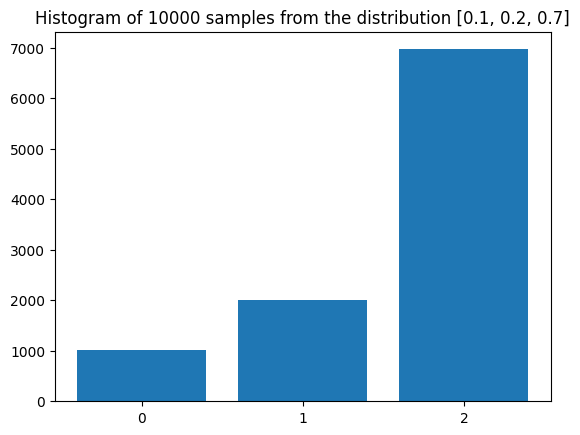

In [11]:
def sample_and_plot_histogram(n: int, dist: List[float]):
    m = len(dist)
    tensor = my_sampler((n, ), dist)
    plt.figure()
    plt.bar(x=range(m), height=tensor.histc(m))
    plt.title(f"Histogram of {n} samples from the distribution {dist}")
    plt.xticks(range(m))
    
    plt.show()

sample_and_plot_histogram(10_000, [0.1, 0.2, 0.7])

# Answer 2

In [4]:
class MyScalar:

    # The value contained in this object.
    value: float

    # A list of `MyScalar`s that this object is created from.
    parents: List["MyScalar"]

    # The immediate derivative of the operation created this object
    # with respect to each of its parents.
    grad: Mapping[int, float]

    def __init__(self,
                 value: float,
                 parents: Optional[List["MyScalar"]] = None,
                 grad: Optional[Mapping[int, float]] = None,
    ):
        """
        Initialize a new MyScalar.

        Usually you would instantiate a new MyScalar object as such:

            MyScalar(5)

        The default arguments are used by our autograd implementation.    
        """
        self.value = value
        self.parents = [] if parents is None else parents
        self.grad = { id(self): 1.0 } if grad is None else grad

    def add(self: MyScalar, other: float) -> MyScalar:
        """ Adds `self` to another `float` """
        value = self.value + other 
        parents = [self]

        # Df/Dself=1
        grad = { id(self): 1 }

        return MyScalar(value, parents, grad)

    def __add__(self: MyScalar, rhs: MyScalar) -> MyScalar:
        value = self.value + rhs.value
        parents = [self, rhs]
        grad = {
                id(self): 1,
                id(rhs): 1,
                }

        return MyScalar(value, parents, grad)

    def __sub__(self: MyScalar, rhs: MyScalar) -> MyScalar:
        value = self.value - rhs.value
        parents = [self, rhs]
        grad = {
                id(self): 1,
                id(rhs): -1,
                }

        return MyScalar(value, parents, grad)

    def sub(self: MyScalar, rhs: float) -> MyScalar:
        value = self.value - rhs
        parents = [self]
        grad = { id(self): 1 }
        return MyScalar(value, parents, grad)

    def __mul__(self: MyScalar, rhs: MyScalar) -> MyScalar:
        value = self.value * rhs.value
        parents = [self, rhs]
        grad = {
                id(self): rhs.value,
                id(rhs): self.value
                }
        return MyScalar(value, parents, grad)

    def mul(self: MyScalar, rhs: float) -> MyScalar:
        value = self.value * rhs
        parents = [self]
        grad = { id(self): rhs }
        return MyScalar(value, parents, grad)

    def __truediv__(self: MyScalar, divisor: MyScalar) -> MyScalar:
        assert divisor.value != 0, "Divisor should be non-zero"
        value = self.value / divisor.value
        parents = [self, divisor]
        grad = {
                id(self): 1 / divisor.value,
                id(divisor): self.value * -1 / (divisor.value**2)
                }
        return MyScalar(value, parents, grad)

    def div(self: MyScalar, divisor: float) -> MyScalar:
        assert divisor != 0, "Divisor should be non-zero"
        value = self.value * divisor
        parents = [self, divisor]
        grad = { id(self): 1 / divisor }
        return MyScalar(value, parents, grad)

    def pow(self: MyScalar, exponent: float) -> MyScalar:
        value = math.pow(self.value, exponent)
        parents = [self]
        grad = { id(self): exponent * math.pow(self.value, exponent - 1) }
        return MyScalar(value, parents, grad)

    def exp(self: MyScalar) -> MyScalar:
        value = math.exp(self.value)
        parents = [self]
        grad = { id(self): value }
        return MyScalar(value, parents, grad)

    def cos(self: MyScalar) -> MyScalar:
        value = math.cos(self.value)
        parents = [self]
        grad = { id(self): -1 * math.sin(self.value) }
        return MyScalar(value, parents, grad)

    def sin(self: MyScalar) -> MyScalar:
        value = math.sin(self.value)
        parents = [self]
        grad = { id(self): math.cos(self.value) }
        return MyScalar(value, parents, grad)

    def log(self: MyScalar) -> MyScalar:
        assert self.value > 0, "Log operand must be positive"

        value = math.log(self.value)
        parents = [self]
        grad = { id(self): 1 / self.value }
        return MyScalar(value, parents, grad)


    def get_gradient(
            self: MyScalar,
            aliases: Optional[Mapping[int, str]] = None,
    ) -> Mapping[str, float]:
        """ Traverse the computational graph and calculate the gradient """
        
        # Immediate gradients are the basecase
        grad = dict(self.grad)

        # Run dfs on the graph, compute the derivatives according to the chain rule.
        stack = list(self.parents)

        while stack:
            node = stack.pop()

            for parent in node.parents:
                # addititive residuals, multiplicative chain rule 
                grad[id(parent)] = grad.get(id(parent), 0) + (grad[id(node)] * node.grad[id(parent)])
                stack.append(parent)

        ans = {}
        aliases = aliases or {}
        for k, v in (grad).items():
            if k in aliases:
                ans[aliases.get(k, str(k))] = v

        return ans

In [6]:
class Tester:
    """ Testing functionality.
    Provides mechanisms to operate on either torch.tensor or MyScalar seemlessly
    and calculates a relative error between the results.
    """
    
    @staticmethod
    def compute_torch_grad(initializers, f):
        tensors = [
                torch.tensor(initializer, requires_grad=True)
                for initializer
                in initializers]

        ans = f(*tensors)
        ans.backward()

        grad = {}
        for i, tensor in enumerate(tensors):
            name = chr(ord('a') + i)
            grad[name] = tensor.grad.item()

        return grad

    @staticmethod
    def compute_custom_grad(initializers, f):
        myscalars = [MyScalar(initializer) for initializer in initializers]

        # Invoke the function
        ans = f(*myscalars)

        # Build the aliases so the keys won't be ids but names "a", "b", "c", ...
        aliases = {}
        for i, myscalar in enumerate(myscalars):
            name = chr(ord('a') + i)
            aliases[id(myscalar)] = name

        # Get the gradient
        return ans.get_gradient(aliases)

    @staticmethod
    def error(a, b):
        """ Calculate the relative error between a and b """
        if max(a, b) == 0:
            return min(a, b)
        return abs(a - b) / max(a, b)

    @staticmethod
    def run(name, argc, f):
        """
        Applies `f` twice - Once on `argc` arguments of type `torch.tensor`
        and once on `argc` arguments of type `MyScalar`.

        
        `f` is assumed to return a mapping from string to
        floats such that the keys are the named variables and the values are the derivatives df/dv_i.
        
        i.e., `f` returns the gradient of `f` but instead in vector form, in keyed form.

        Then, compare the derivatives of the two implementations (torch.tensor vs MyScalar).
        If the relative error between to such derivatives is not negligible, raise an assertion error.
        """
        print(f"{name}")

        initializers = [random() for _ in range(argc)]
        custom_grad = Tester.compute_custom_grad(initializers, f)
        torch_grad = Tester.compute_torch_grad(initializers, f)

        assert custom_grad.keys() == torch_grad.keys(), "Torch and Custom grads yielded different leafs"

        for k, custom_val in custom_grad.items():
            torch_val = torch_grad[k]
            error = Tester.error(custom_val, torch_val) 
            print(f" - {k}, error={round(error, 3)}, custom_grad={custom_val}, torch_grad={torch_val}")
            assert error < 0.1, f"Torch and Custom grad[{k}] differ"
            print()

# Multiple test cases to invoke using the Tester
test_cases = [
        ("exp", 1, lambda a: a.exp()),

        ("a + b", 2, lambda a, b: a + b),
        ("a - b", 2, lambda a, b: a - b),
        ("a * b", 2, lambda a, b: a * b),
        ("a / b", 2, lambda a, b: a / b),

        ("ln", 1, lambda a: a.log()),

        ("large power", 1, lambda a: a.pow(5)),
        ("zero power", 1, lambda a: a.pow(0)),
        ("fractional power", 1, lambda a: a.pow(0.3)),
        ("negative power", 1, lambda a: a.pow(-4.0)),

        ("cos", 1, lambda a: a.cos()),
        ("sin", 1, lambda a: a.sin()),

        ("complex graph, such that a is used in more than one branch",
         4,
         lambda a, b, c, d: ((a.log() / b.sin()) + (a.cos() * c) - (a + d.exp())).pow(2)
         ),

        ("chain operations",
         1,
         lambda a: a.pow(2).cos().sin().sin().exp().pow(3).log() / a + a * a
         )
    ]

# Invoke all test cases using the Tester
for name, argc, f in test_cases:
    Tester.run(name, argc, f)

exp
 - a, error=0.0, custom_grad=1.555506923947372, torch_grad=1.555506944656372

a + b
 - a, error=0.0, custom_grad=1, torch_grad=1.0

 - b, error=0.0, custom_grad=1, torch_grad=1.0

a - b
 - a, error=0.0, custom_grad=1, torch_grad=1.0

 - b, error=-0.0, custom_grad=-1, torch_grad=-1.0

a * b
 - a, error=0.0, custom_grad=0.03279016524671019, torch_grad=0.0327901653945446

 - b, error=0.0, custom_grad=0.4715543463891513, torch_grad=0.47155433893203735

a / b
 - a, error=0.0, custom_grad=2.9146548198412834, torch_grad=2.9146547317504883

 - b, error=-0.0, custom_grad=-1.1783185632242437, torch_grad=-1.1783186197280884

ln
 - a, error=0.0, custom_grad=2.293826397529669, torch_grad=2.2938263416290283

large power
 - a, error=0.0, custom_grad=0.9852035229812433, torch_grad=0.9852036833763123

zero power
 - a, error=0.0, custom_grad=0.0, torch_grad=0.0

fractional power
 - a, error=0.0, custom_grad=0.5541547092684139, torch_grad=0.5541546940803528

negative power
 - a, error=-0.0, custom_gr